In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
# Cargar los datos
data = pd.read_csv('train.csv')

# Eliminar columnas con muchos valores faltantes
missing_values = data.isnull().sum() / len(data) * 100
columns_to_drop = missing_values[missing_values > 30].index
data = data.drop(columns=columns_to_drop)

# Eliminar filas con valores faltantes en columnas importantes
data = data.dropna(subset=['SalePrice', 'GrLivArea', 'TotalBsmtSF', 'GarageArea'])

# Crear variable categórica para precio
data['PriceCategory'] = pd.cut(data['SalePrice'], 
                              bins=[5000, 150000, 300000, float('inf')], 
                              labels=['Barata', 'Media', 'Cara'])

# Separar características y variable objetivo
X = data.drop(['Id', 'SalePrice', 'PriceCategory'], axis=1)
y_class = data['PriceCategory']
y_reg = data['SalePrice']

# Codificar variables categóricas
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Imputar valores faltantes con la mediana
X = X.fillna(X.median())

# Dividir los datos en conjuntos de entrenamiento y prueba (usando misma semilla que en entregas anteriores)
X_train, X_test, y_train_class, y_test_class, y_train_reg, y_test_reg = train_test_split(
    X, y_class, y_reg, test_size=0.3, random_state=42)

# Estandarizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Modelo 1 - Una capa oculta (relu):
              precision    recall  f1-score   support

      Barata       0.91      0.92      0.91       198
        Cara       0.69      0.73      0.71        37
       Media       0.87      0.85      0.86       203

    accuracy                           0.87       438
   macro avg       0.82      0.83      0.83       438
weighted avg       0.87      0.87      0.87       438



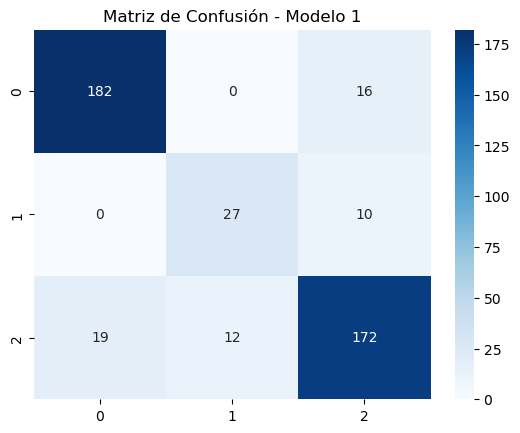

In [3]:
# Modelo 1: Una capa oculta con función de activación relu
model_clf1 = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', 
                          solver='adam', max_iter=500, random_state=42)
model_clf1.fit(X_train_scaled, y_train_class)

# Predicciones
y_pred_clf1 = model_clf1.predict(X_test_scaled)

# Matriz de confusión
print("Modelo 1 - Una capa oculta (relu):")
print(classification_report(y_test_class, y_pred_clf1))
cm1 = confusion_matrix(y_test_class, y_pred_clf1)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Modelo 1')
plt.show()

Modelo 2 - Dos capas ocultas (tanh):
              precision    recall  f1-score   support

      Barata       0.89      0.91      0.90       198
        Cara       0.68      0.73      0.70        37
       Media       0.87      0.83      0.85       203

    accuracy                           0.86       438
   macro avg       0.81      0.83      0.82       438
weighted avg       0.86      0.86      0.86       438



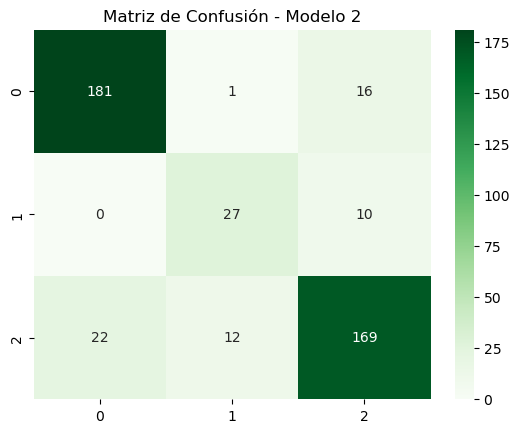

In [4]:
# Modelo 2: Dos capas ocultas con función de activación tanh
model_clf2 = MLPClassifier(hidden_layer_sizes=(50, 25), activation='tanh', 
                          solver='adam', max_iter=500, random_state=42)
model_clf2.fit(X_train_scaled, y_train_class)

# Predicciones
y_pred_clf2 = model_clf2.predict(X_test_scaled)

# Matriz de confusión
print("Modelo 2 - Dos capas ocultas (tanh):")
print(classification_report(y_test_class, y_pred_clf2))
cm2 = confusion_matrix(y_test_class, y_pred_clf2)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusión - Modelo 2')
plt.show()

In [5]:
# Comparación de precisión
from sklearn.metrics import accuracy_score

acc1 = accuracy_score(y_test_class, y_pred_clf1)
acc2 = accuracy_score(y_test_class, y_pred_clf2)

print(f"Precisión Modelo 1: {acc1:.4f}")
print(f"Precisión Modelo 2: {acc2:.4f}")

# Análisis de sobreajuste
train_acc1 = accuracy_score(y_train_class, model_clf1.predict(X_train_scaled))
train_acc2 = accuracy_score(y_train_class, model_clf2.predict(X_train_scaled))

print(f"\nPrecisión en entrenamiento Modelo 1: {train_acc1:.4f}")
print(f"Precisión en prueba Modelo 1: {acc1:.4f}")
print(f"Diferencia: {train_acc1 - acc1:.4f}")

print(f"\nPrecisión en entrenamiento Modelo 2: {train_acc2:.4f}")
print(f"Precisión en prueba Modelo 2: {acc2:.4f}")
print(f"Diferencia: {train_acc2 - acc2:.4f}")

Precisión Modelo 1: 0.8699
Precisión Modelo 2: 0.8607

Precisión en entrenamiento Modelo 1: 1.0000
Precisión en prueba Modelo 1: 0.8699
Diferencia: 0.1301

Precisión en entrenamiento Modelo 2: 1.0000
Precisión en prueba Modelo 2: 0.8607
Diferencia: 0.1393


In [14]:
# Optimización de hiperparámetros para el mejor modelo
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

grid_search = GridSearchCV(MLPClassifier(max_iter=500, random_state=42), 
                          param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train_class)

print("Mejores parámetros:", grid_search.best_params_)
best_model_clf = grid_search.best_estimator_
y_pred_best_clf = best_model_clf.predict(X_test_scaled)

print("\nMejor modelo optimizado:")
print(classification_report(y_test_class, y_pred_best_clf))

Mejores parámetros: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001}

Mejor modelo optimizado:
              precision    recall  f1-score   support

      Barata       0.91      0.92      0.91       198
        Cara       0.69      0.73      0.71        37
       Media       0.87      0.85      0.86       203

    accuracy                           0.87       438
   macro avg       0.82      0.83      0.83       438
weighted avg       0.87      0.87      0.87       438



In [6]:
# Modelo de regresión con una capa oculta
model_reg1 = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', 
                         solver='adam', max_iter=1000, random_state=42)
model_reg1.fit(X_train_scaled, y_train_reg)

# Predicciones
y_pred_reg1 = model_reg1.predict(X_test_scaled)

# Métricas
mse1 = mean_squared_error(y_test_reg, y_pred_reg1)
r2_1 = r2_score(y_test_reg, y_pred_reg1)

print(f"Modelo 1 - MSE: {mse1:.2f}, R2: {r2_1:.4f}")

Modelo 1 - MSE: 21572757718.36, R2: -2.0915


/usr/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [7]:
# Modelo de regresión con múltiples capas ocultas
model_reg2 = MLPRegressor(hidden_layer_sizes=(50, 25, 10), activation='tanh', 
                         solver='adam', max_iter=1000, random_state=42)
model_reg2.fit(X_train_scaled, y_train_reg)

# Predicciones
y_pred_reg2 = model_reg2.predict(X_test_scaled)

# Métricas
mse2 = mean_squared_error(y_test_reg, y_pred_reg2)
r2_2 = r2_score(y_test_reg, y_pred_reg2)

print(f"Modelo 2 - MSE: {mse2:.2f}, R2: {r2_2:.4f}")

Modelo 2 - MSE: 39355265819.86, R2: -4.6398


/usr/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Comparación de modelos de regresión:
Modelo 1 (1 capa) - MSE: 21572757718.36, R2: -2.0915
Modelo 2 (3 capas) - MSE: 39355265819.86, R2: -4.6398


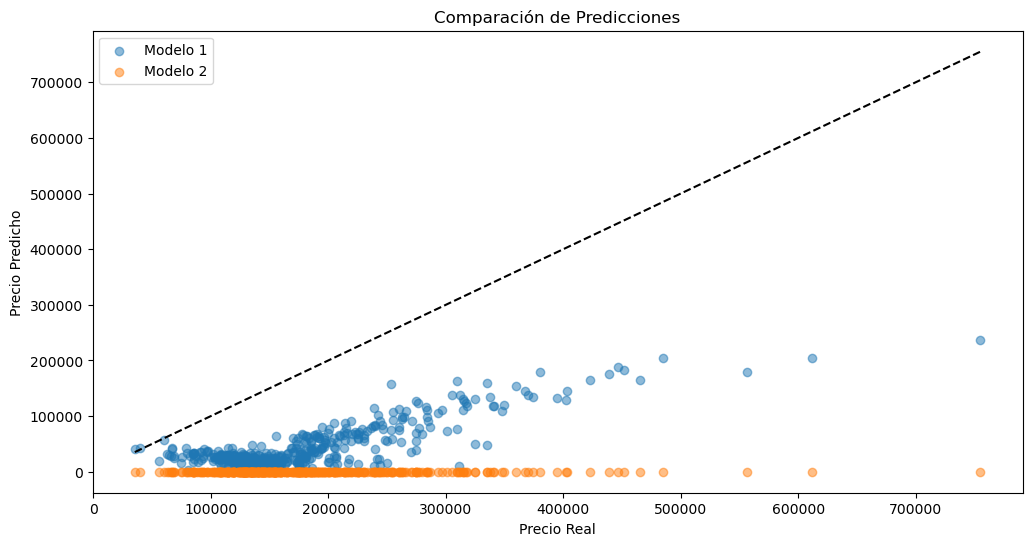

In [8]:
# Comparación de modelos
print("Comparación de modelos de regresión:")
print(f"Modelo 1 (1 capa) - MSE: {mse1:.2f}, R2: {r2_1:.4f}")
print(f"Modelo 2 (3 capas) - MSE: {mse2:.2f}, R2: {r2_2:.4f}")

# Gráfico de predicciones vs valores reales
plt.figure(figsize=(12, 6))
plt.scatter(y_test_reg, y_pred_reg1, alpha=0.5, label='Modelo 1')
plt.scatter(y_test_reg, y_pred_reg2, alpha=0.5, label='Modelo 2')
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--')
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')
plt.title('Comparación de Predicciones')
plt.legend()
plt.show()

In [9]:
# Optimización de hiperparámetros para el mejor modelo de regresión
param_grid_reg = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

grid_search_reg = GridSearchCV(MLPRegressor(max_iter=1000, random_state=42), 
                             param_grid_reg, cv=5, scoring='r2')
grid_search_reg.fit(X_train_scaled, y_train_reg)

print("Mejores parámetros para regresión:", grid_search_reg.best_params_)
best_model_reg = grid_search_reg.best_estimator_
y_pred_best_reg = best_model_reg.predict(X_test_scaled)

mse_best = mean_squared_error(y_test_reg, y_pred_best_reg)
r2_best = r2_score(y_test_reg, y_pred_best_reg)

print(f"\nMejor modelo optimizado - MSE: {mse_best:.2f}, R2: {r2_best:.4f}")

/usr/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarni

Mejores parámetros para regresión: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 25), 'learning_rate_init': 0.01}

Mejor modelo optimizado - MSE: 1315405560.67, R2: 0.8115


/usr/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


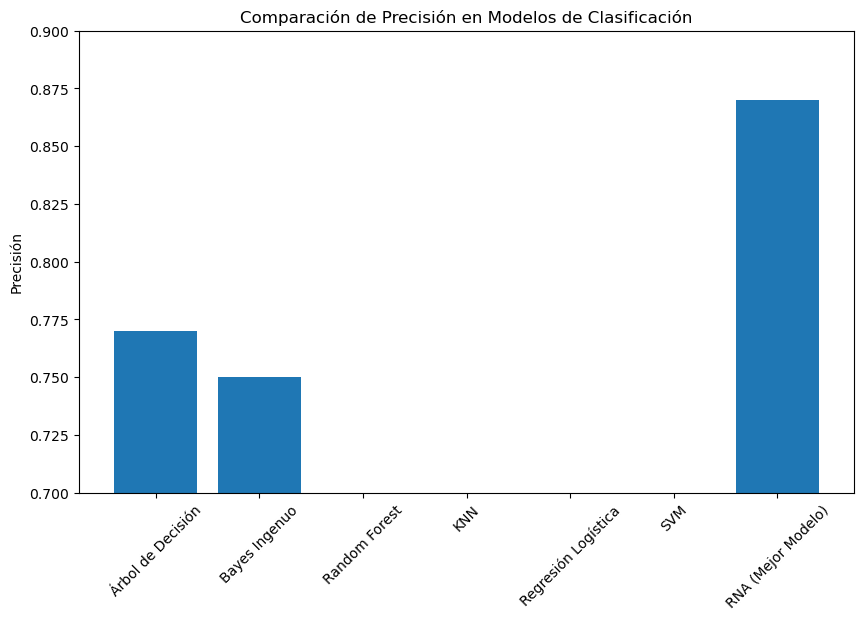

In [18]:
results_clf = {
    'Árbol de Decisión': 0.77,
    'Bayes Ingenuo': 0.75,
    'Random Forest': 0,
    'KNN': 0,
    'Regresión Logística': 0,
    'SVM': 0,
    'RNA (Mejor Modelo)': accuracy_score(y_test_class, y_pred_best_clf)
}

# Gráfico de comparación
plt.figure(figsize=(10, 6))
plt.bar(results_clf.keys(), results_clf.values())
plt.ylim(0.7, 0.9)
plt.title('Comparación de Precisión en Modelos de Clasificación')
plt.ylabel('Precisión')
plt.xticks(rotation=45)
plt.show()

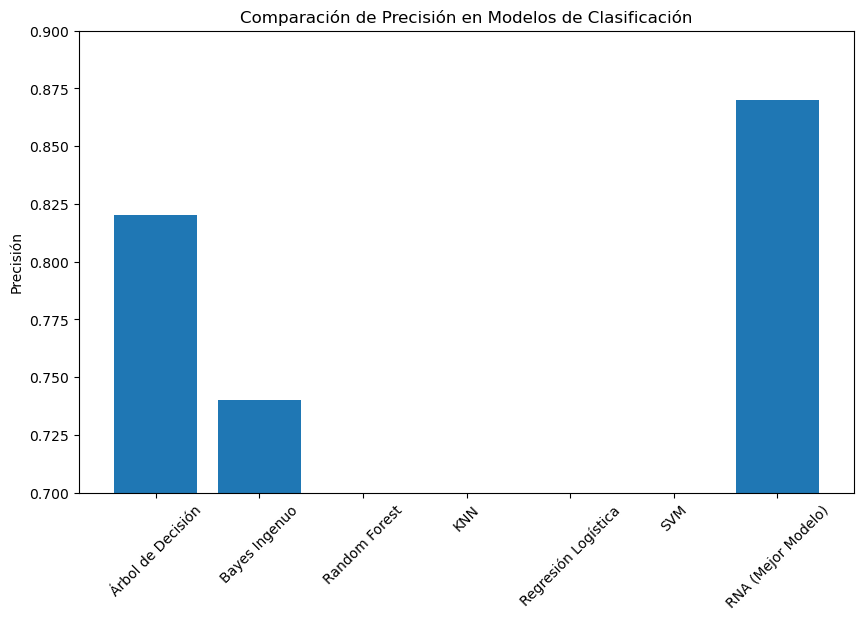

In [19]:
results_clf = {
    'Árbol de Decisión': 0.82,
    'Bayes Ingenuo': 0.74,
    'Random Forest': 0,
    'KNN': 0,
    'Regresión Logística': 0,
    'SVM': 0,
    'RNA (Mejor Modelo)': accuracy_score(y_test_class, y_pred_best_clf)
}

# Gráfico de comparación
plt.figure(figsize=(10, 6))
plt.bar(results_clf.keys(), results_clf.values())
plt.ylim(0.7, 0.9)
plt.title('Comparación de Precisión en Modelos de Clasificación')
plt.ylabel('Precisión')
plt.xticks(rotation=45)
plt.show()

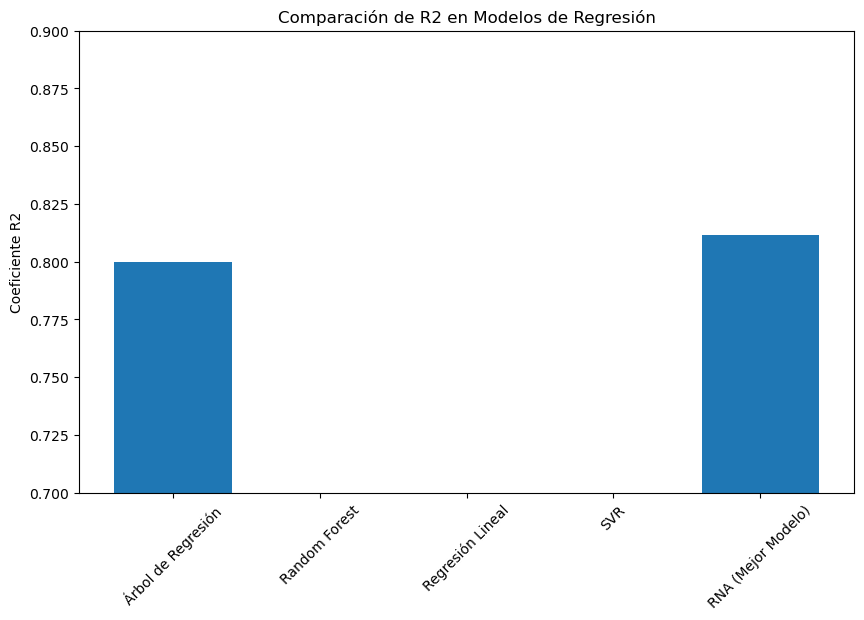

In [20]:
# Resultados hipotéticos basados en entregas anteriores (debes reemplazar con tus resultados reales)
results_reg = {
    'Árbol de Regresión': 0.80,
    'Random Forest': 0,
    'Regresión Lineal': 0,
    'SVR': 0,
    'RNA (Mejor Modelo)': r2_best
}

# Gráfico de comparación
plt.figure(figsize=(10, 6))
plt.bar(results_reg.keys(), results_reg.values())
plt.ylim(0.7, 0.9)
plt.title('Comparación de R2 en Modelos de Regresión')
plt.ylabel('Coeficiente R2')
plt.xticks(rotation=45)
plt.show()